# Load Libraries

load initial packages here

write instructions for setting up anaconda and jup nb

Generated a 'symbolic link' for the Passport external drive at '/Documents/MyPassport1' so that I can use my backup drive to store this markdown and the associated files - 
notes on __[this:](https://carpediemsystems.co.uk/2015/10/08/os-x-ipython-notebooks-on-an-an-external-drive-with-anaconda/)__


In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os,sys,glob
import pandas as pd
from scipy.stats import ttest_ind,norm
import statsmodels.api as sm
import seaborn as sns
import itertools
import bioframe
import math



/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Define Functions

We define all functions prior to running the analysis. Each function defined below is called later in the analysis step for calculating contact probability scaling. Scaling analysis is based on work published in __[Sanborn et al. 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1518552112)__ and __[E Lieberman-Aiden, et al.,2009](https://pubmed.ncbi.nlm.nih.gov/19815776/)__

**Notes for myself**
<br>
- Plot slope v distance as a line plot (derivative of contact probability)
<br>
- Check number of domains and size of domains 
<br>
- Paper where we only look at S for HiC datasets of different drugs/degrons

### Set_Fig()
The first function defines the parameters for each of the figures generated below in each step of the analysis, returning a Figure parameters and Axis parameters object



In [2]:
##--------------------------------Set up the figure frames--------------------------------##

def set_fig(row, colume,l=8,h=8):
    fig, ax = plt.subplots(row, colume,figsize=(colume*l,row*h))# ax2=fig.add_subplot(2,2,1)
    plt.rc('text',usetex=False)
    font = {'family':'serif','size':32,'weight':'normal'}

    plt.rc('font',**font)
    plt.rc('lines', linewidth=2, color='r')

    plt.rcParams['axes.linewidth'] = 1
    plt.rcParams['font.size'] = 27
    plt.rcParams['axes.labelsize'] = 27
    plt.rcParams['axes.titlesize'] = 27
    plt.rcParams['legend.fontsize'] = 25

    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.major.size'] = 27
    plt.rcParams['xtick.minor.size'] = 15
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 27
    plt.rcParams['ytick.minor.size'] = 15
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2

    params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
    plt.rcParams.update(params)
    fig.tight_layout()
    return(fig,ax)

### Parse_Contacts()
This function parses the contact data generated from either the Juicer Tools Dump utility (get_contacts.sh) or HiC Straw utilily (this has replaced Dump recently). Contacts are dumped in the format ```pos1 pos2 frequency ``` in a file written as ```chr#-observed_resKb.txt```

**Input:** File with all of Hi-C contacts for a given chromosome recorded from .hic file (generated by Juicer Analysis),path to output parsed contacts file to write to, size (in bp) of chromosome, resolution of contact matrix
<br>
**Output:** Writes to file with observed contacts vs. linear distance (based on matrix resolution).
<br>
<br>
**Step 1:** Read data in and get contact distance between position 1 and position 2 from the contacts files.

**Read in data**

```
contacts_all:
             pos1      pos2          freq
0           10000     10000  10675.597000
1           20000     20000    898.710940
2           30000     30000   1191.079000
3           30000     35000     26.308973
4           35000     35000    101.115210
...           ...       ...           ...
1124378  90015000  90215000     12.131360
1124379  90075000  90215000     53.917152
1124380  90085000  90215000     48.525440
1124381  90215000  90215000   1852.789400
1124382  90220000  90220000  16013.395000
```

**Get distance between positon 1 and position 2**

```
contacts_all distance:
0               0
1               0
2               0
3            5000
4               0
            ...  
1124378    200000
1124379    140000
1124380    130000
1124381         0
1124382         0
```

<br>

**Step 2:** Generate an index of contact distances for each chromosome (start:0, end:chrom size, interval:chrom size/resolution) from smallest distance to largest distance at resolution-sized intervals.

<br>

```
contacts
         chr16
0          NaN
25000      NaN
50000      NaN
75000      NaN
100000     NaN
...        ...
90250000   NaN
90275000   NaN
90300000   NaN
90325000   NaN
90350000   NaN
```

**Step 3:** Sum the frequencies for each contact distance *for each chromosome* and export as parsed contacts. This step will output a list of genomic distances at resolution-sized intervals *for each chromosome*, from the smallest distance to the largest, with the summed contact frequencies for each genomic distance, into a directory labeled ```/contacts_parsed```

```
                   chr16
0         5092223.186643
25000        6134.937518
50000        3194.713279
75000        2406.680823
100000        1931.36479
...                  ...
90250000             0.0
90275000             0.0
90300000             0.0
90325000             0.0
90350000             0.0
```

In [3]:
##--------------------------------Parse All Contacts--------------------------------##

def parse_contacts(input_file,output_path,chrom_size,res=25000):
    label = input_file.split('/')[-1].split('-')[0]
    
    # Step 1: Read data in
    contacts_all = pd.read_csv(input_file,sep='\t',header=None)
    contacts_all = contacts_all.rename(columns={0:'pos1',1:'pos2',2:'freq'})
    contacts_all['dist'] = np.abs(contacts_all['pos1'] - contacts_all['pos2']) #Get distance (in bp) between all observed contacts
    
    # Step 2: Construct a new dataframe to store number of contacts at a given distance
    inds = np.linspace(int(0),int(chrom_size),(int(chrom_size/res)+1)).astype(int)
    contacts = pd.DataFrame(index=inds,columns=[label])
    
    # Step 3: Export data frame with distance and summed frequency for each distance
    for dist in inds:
        contacts.loc[dist] = contacts_all[contacts_all['dist']==dist]['freq'].sum()
    contacts.to_csv(output_path+label+'_contacts_'+str(int(res/1000))+'kb.csv',header='True',sep='\t')

### Calc_Cont_Prob()

**note:** I had to make some modifications to this code to process the replicates separately because we did not merge the replicates 
<br>
<br>
This function takes in the parsed contacts generated by ```parse_contacts()``` and calculates the normalized contact probability for each genomic distance at resolution-sized intervals
<br>
**Step 1:** Create a dataframe with genomic distance as the index and the contact frequences for each chromosome appended row-wise to each distance. 
<br>
**Step 2:** Take data frame from previous step and calculate contact probability for each chromosome. *As contact distance increases, all possible contacts decreases. At the max length of a chromosome, only one possible contact can be made. At the min length (length of a single resolution, res * chrom_size = max # of possible contacts.* These possible contacts for each distance are used to find the contact probability.
<br>
**Possible contacts for each genomic distance:**
<br>
```
                0
25000      9687.0
50000      9686.0
75000      9685.0
100000     9684.0
125000     9683.0
...           ...
242125000     3.0
242150000     2.0
242175000     1.0
242200000     0.0
242225000    -1.0
```
<br>

**contact probability (contact freq/all possible contacts) for each genomic distance:**

<br>

```
25000.0        4.097441
50000.0        2.146457
75000.0        1.542758
100000.0       1.251653
125000.0       1.069227
                 ...   
242125000.0    0.000000
242150000.0    0.000000
242175000.0         NaN
242200000.0   -0.000000
242225000.0         NaN
Name: chr4, Length: 9689, dtype: float64
```

<br>

**Step 3:** Sum all of the contact frequencies for each chromosome at each genomic distance

<br>

```
25000.0        12.767640
50000.0         6.988783
75000.0         5.095226
100000.0        4.145185
125000.0        3.503170
                 ...    
242125000.0     0.000000
242150000.0     0.000000
242175000.0     0.000000
242200000.0     0.000000
242225000.0     0.000000
Length: 9689, dtype: float64
```

<br>

**Step 4:** Normalize the contact frequency for each genomic distance by dividing each frequency by the sum of all frequencies. We now have a contact probability at each genomic distance for our data. The final output is written to file and saved for future steps.

<br>

```
25000.0        0.085055
50000.0        0.046558
75000.0        0.033943
100000.0       0.027614
125000.0       0.023337
                 ...   
242125000.0    0.000000
242150000.0    0.000000
242175000.0    0.000000
242200000.0    0.000000
242225000.0    0.000000
```

<br>

**Input:** contact files with number of contacts observed vs. genomic distance (bp), output file path and name, matrix resolution of parsed contacts
<br>
**Output:** contact probability files with normalized contact probability vs. genomic distance (bp)
<br>
*Note: contact probability calculated based off of Sanborn et al. 2015
I(s) = I_actual(s)/I_possible(s) where I_possible(s) = N-s-1 for chain of length N*

In [4]:
##--------------------------------Calculate Contact Probability--------------------------------##

def calc_cont_prob(input_path,output_path,output_name,res=25000,merge_rep=True):
    
    # If merge_rep = T, uses wildcard to merge calculation for all reps of a single condition
    if (merge_rep):
        input_files = sorted(glob.glob(input_path+'**/contacts_parsed/*contacts_'+str(int(res/1000))+'kb.csv'), key=os.path.getsize,reverse=True)
    else: # No merged reps
        input_files = sorted(glob.glob(input_path+'*contacts_'+str(int(res/1000))+'kb.csv'), key=os.path.getsize,reverse=True)
    output_file = output_name + '_cont_prob_'+str(int(res/1000))+'kb.csv'

    # Step 1: Create dataframe with contacts vs. genomic distance for all chromosomes in all replicates
    # Construct a new dataframe to store number of contacts at a given distance
    contacts_all = pd.DataFrame()

    rows = len(contacts_all.axes[0])
    cols = len(contacts_all.axes[1])

    
    # Enumerate stores output in two variables, index and file
    for i,file in enumerate(input_files): 
        contacts = pd.read_csv(file,sep='\t') # Read in files
        contacts = contacts.rename(columns={'Unnamed: 0':'dist'}) # Rename column 1 to 'distance'

        # Concatenate the first chromosome's contact frequencies
        if i==0: 
            contacts_all = pd.concat([contacts_all,contacts])
        # Merge the remaining chromosomal contact frequencies
        else: 
            contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
        print(contacts_all)
        
    contacts_all = contacts_all.set_index('dist') # Set the index for DF to 'genomic distance'
    contacts_all[np.isnan(contacts_all)] = 0 # Set all NAs to 0
    
    # Step 2: Correct by *all* possible pairs to calculate contact probability for each chromosome
    ind = np.linspace(resolution,resolution*len(contacts_all),len(contacts_all)) # Generates contact distance index
    cont_prob_chroms = pd.DataFrame(columns=contacts_all.columns,index=ind) # Generates an empty data frame for contact probability
    
    for i,chrom in enumerate(contacts_all): # Iterate through each chromosome
        len_chain = contacts_all[chrom].iloc[:, 0].count() # Get total number of contacts for each chrom
        
        n=1
        length = 9972
        
        contacts_possible = np.repeat(len_chain-n,len(contacts_all)) - np.linspace(n,len(contacts_all),len(contacts_all))
        ind = np.linspace(resolution,resolution*len(contacts_all),len(contacts_all))
        
        # Generate data frame with possible contacts in one column and index (distances) in the other column
        contacts_possible = pd.DataFrame(contacts_possible,index=ind.astype(int)) 

        # Move *contact freq/all possible contacts* into data frame
        cont_prob_chroms[chrom] = pd.DataFrame(contacts_all/contacts_possible.values)[chrom]
        
    cont_prob_chroms[cont_prob_chroms < 0] = 0 # Replace negative values with 0
    cont_prob_chroms = cont_prob_chroms.replace([np.inf, np.nan], 0) # Replace non-integers with 0
    
    # Step 3: Sum over all contact probabilities for all chromosomes
    cont_prob = cont_prob_chroms.sum(axis=1)

    # Step 4: Normalize corrected contacts to create probability distribution
    cont_prob = cont_prob/(cont_prob.sum())
    print(cont_prob)
    
    cont_prob.to_csv(output_path+output_file,header=['cont_prob'])
    

### calc_cont_prob_scaling()
This function uses __[Ordinary Least Squares](https://setosa.io/ev/ordinary-least-squares-regression/)__ linear regression to find S, the contact probability scaling exponent, from the contact data and relate it to D.  Probability of contact has the following relationship:𝑃 ∝ 𝑁^(−𝑠). It's relationship to D: 𝑆=  3/𝐷 . Variables that need to be set: Start of regression analysis; End of regression analysis (in genomic distance). Vary these values to find S at different length scales. Documentation for the Python package used below can be found at __[Stats Models](https://www.statsmodels.org/stable/index.html)__


**Step1:** Read in the contact probability file written out in the previous function, ```calc_cont_prob```
<br>

```
Contact:       Cont Prob:
25000.0       0.092018
50000.0       0.049839
75000.0       0.036258
100000.0      0.029143
125000.0      0.026127
...                ...
248900000.0   0.000000
248925000.0   0.000000
248950000.0   0.000000
248975000.0   0.000000
249000000.0   0.000000
```
<br>

**log values of genomic distances within fitting range**

<br>

```
dist
Float64Index([ 5.720159303405957,  5.740362689494244, 5.7596678446896306,
               5.778151250383644,  5.795880017344075,  5.812913356642856,
               5.829303772831025,  5.845098040014257,  5.860338006570994,
                 5.8750612633917,
              ...
                6.78354628227035,  6.785329835010767,   6.78710609303657,
               6.788875115775417,  6.790636961931703, 6.7923916894982534,
               6.794139355767774,  6.795880017344075,  6.797613730153076,
               6.799340549453582],
             dtype='float64', length=232)
```

<br>

**Log of contact probabilities within fitting range**

<br>

```
contact fit
[[-2.02262054]
 [-2.11558031]
 [-2.13669344]
 [-2.16807778]
 [-2.1746474 ]
 [-2.19257387]
 [-2.21753804]
 [-2.23695088]
 [-2.23536953]
 [-2.25768597]...
```

<br>

**Step2:** Perform least squares fit to contact probability curve. ```s_mean``` is the S exponent that tells us what the contact scaling is within the region where the regression analysis was done. ```s_intercept``` is the log value where the line intersects the contact probability curve

<br>

```
          label    s_mean s_intercept     s_err     s_std s_rsquared
CTRL_mega  CTRL -1.340508    5.619405  0.007128  0.029582   0.993539
```

<br>

**Input:** contact probability file, np.log10 start and end position for regression fit
<br>
**Output:** linear regression fit mean and standard error (error based on linear regression error)

In [5]:
# Input: contact probability file, np.log10 start and end position for regression fit
# Output: linear regression fit mean and standard error (error based on linear regression error)

def calc_cont_prob_scaling(input_file,start,end):
    # Read in file containing contact probability
    cont_prob = pd.read_csv(input_file,index_col=0)

    # Perform least squares fit to data
    fitting_range = ((np.log10(cont_prob.index)>start)&(np.log10(cont_prob.index)<end))
    dist = np.log10(cont_prob.index)[fitting_range]
    cont_prob_fit = np.log10(cont_prob.values[fitting_range])
    
    dist = sm.add_constant(dist, prepend=False)
    model = sm.OLS(cont_prob_fit,dist)
    result = model.fit()
    
    return result

### calc_cont_prob_scaling_mwa()
This function generates the contact probability scaling regression analysis using a moving window average to find S across a user defined window of base pairs. Some background can be found __[here](https://moultano.wordpress.com/2021/01/27/use-local-linear-regression-instead-of-a-moving-average/)__ . The window is in log 10 base pairs. The MWA analysis will roll through the region defined by the start and end point (also in log 10) and for every N window, it will calculate the derivative of the contact probability (S) and move up by one to the next N window. All the values of S and the intercept will be collected into a data frame for each genomic distance.
<br>

**Initial temp data frame created to store moving window of 5**

<br>

```
dist  cont_prob  intercept  CTRL_mega
0  5.096910  -1.582916        NaN        NaN
1  5.176091  -1.660573        NaN        NaN
2  5.243038  -1.696496        NaN        NaN
3  5.301030  -1.686894        NaN        NaN
4  5.352183  -1.776900        NaN        NaN

```

<br>

**Once the MWA regression is complete:**

<br>

```
        dist  cont_prob  intercept  CTRL_mega
8   5.511883  -1.905885   3.523092  -0.986773
9   5.544068  -1.938364   2.299409  -0.762055
10  5.574031  -1.967602   2.548885  -0.808186
11  5.602060  -1.984873   3.349991  -0.953726
12  5.628389  -2.005582   3.337663  -0.951054

```

<br>

**Input:** contact probability file, np.log10 start and end position for fit, size of moving window (in bp), resolution of hi-c map
<br>
**Output:** moving window average regression fit to calculate contact probability scaling

In [6]:
# Input: contact probability file, np.log10 start and end position for fit, size of moving window (in bp), resolution of hi-c map
# Output: moving window average regression fit to calculate contact probability scaling

def calc_cont_prob_scaling_mwa(input_file,start,end,window,res=25000):
    # Read in file containing contact probability
    cont_prob = pd.read_csv(input_file,index_col=0)
    fname = input_file.split('/')[-1].split('_')[:2]
    separator = '_'
    cond = separator.join(fname)

    # Set up dataframe to fit cont prob to genomic distance
    fitting_range = ((np.log10(cont_prob.index)>start)&(np.log10(cont_prob.index)<end))
    num_fit = str(sum(fitting_range))
    dist_fit = np.log10(cont_prob.index)[fitting_range]
    mwa_fit = pd.DataFrame(index=dist_fit,columns=['cont_prob'],data=np.log10(cont_prob.values[fitting_range]).flatten())
    mwa_fit.reset_index(level=0, inplace=True)
    mwa_fit = mwa_fit.rename(columns={'index':'dist'})

    mwa_fit['intercept'] = np.nan #constant
    mwa_fit[cond] = np.nan #beta1 (i.e. s)
    
    # Perform moving window average regression fit
    for i in range(window,len(mwa_fit)):
        temp = mwa_fit.iloc[i-window:i,:]
        RollOLS = sm.OLS(temp.loc[:,'cont_prob'],sm.add_constant(temp.loc[:,['dist']])).fit()
        mwa_fit.iloc[i,mwa_fit.columns.get_loc('intercept')] = RollOLS.params[0]
        mwa_fit.iloc[i,mwa_fit.columns.get_loc(cond)] = RollOLS.params[1]
    return num_fit,mwa_fit[['dist',cond]]

In [7]:
#### Function used to look at quantiles for violinplots ###########

def adjacent_values(vals,q1,q3):
    upper_adjacent_value = q3 + (q3 - q1)*1.5
    upper_adjacent_value = np.clip(upper_adjacent_value,q3,vals[-1])
    
    lower_adjacent_value = q3 - (q3 - q1)*1.5
    lower_adjacent_value = np.clip(lower_adjacent_value,vals[0],q1)
    return lower_adjacent_value, upper_adjacent_value

# Main Method: Calculate Contact Probability 


### All Contacts
**NOTES ON DIRECTORY STRUCTURE**

#### BEFORE ANALYSIS:
<br>
1. all Hi-C contact and analysis should be stored under <span style="color:green">hic_analysis_path</span>
<br>
2. <span style="color:green">hic_analysis_path/experiment_name/contact_data</span> should store all contact data obtained from Juicer maps for each experiment
<br>
3. <span style="color:green">hic_analysis_path/experiment_name/contact_data/cond_name/rep_name</span> should contain contacts folder with contact information by chromosome

#### AFTER ANALYSIS:
<br>
1. <span style="color:blue">hic_analysis_path/experiment_name/contact_data/cond_name/rep_name</span> should contain <span style="color:blue">contacts_parsed</span>  folder with contact information vs. genomic distance by chromosome
<br>
2. <span style="color:blue">hic_analysis_path/experiment_name/cont_prob_analysis/cont_prob</span> should contain all information pertaining to contact probability organized by conditions
<br>
3. <span style="color:blue">hic_analysis_path/experiment_name/cont_prob_analysis/cont_prob/cond_name</span> should contain contact probabilities for each replicate
<br>
4. <span style="color:blue">hic_analysis_path/experiment_name/cont_prob_analysis/results</span> should contain results (plots and statistics) from contact probabilty analysis
 
Below is the main method where the directory structure for your analysis is defined, the conditions and variables are defined, chromosome data is retrieved, and results directories are generated if they don't already exist. Following that, ```parse_contacts()``` is called to generate the parsed contact files for each distance in the first cell and these are fed into ```calc_cont_prob()``` to calculate the contact probabilities at each genomic distance in the second cell

### 1. Parse all contacts here:

In [6]:
##--------------------------------Main Method: Parse Contacts--------------------------------##

## Step 1: Define HiC data directory structure
hic_analysis_path = '/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/'
experiment_name = 'Lamin_HiC'
global_path = hic_analysis_path+experiment_name

contacts_dir = '/contact_data/'
observed_contacts_dir = '/contacts/'
contacts_parsed_dir = '/contacts_parsed/'

conds = ['24hrAuxin','untreated', 'withdraw'] # name of condition directories to analyze
cond_labels = ['24hrAuxin','untreated', 'withdraw'] # corresponding condition labels

## Step 2: Define variables--------------------------------------------------##
genome = 'hg19' # genome Hi-C map aligned to 
resolution = 25000 # contact matrix resolution

## Step 3: Create a dictionary containing labels for each condition analyzed-##
labels_dict = dict(zip(conds, cond_labels)) 
print(labels_dict)

## Step 4: Get chromosomes and chromosome sizes using the bioframe package---##
chrom_sizes = bioframe.fetch_chromsizes(genome)
chromosomes = list(chrom_sizes.index)[:-2]
print(chromosomes)

## Step 5: Directory structure for contact probability analysis results------##
cont_prob_analysis = global_path+'/cont_prob_analysis/'
if not os.path.exists(cont_prob_analysis):
    os.mkdir(cont_prob_analysis)
    
output_path_cont_prob_all = cont_prob_analysis+'cont_prob/'
if not os.path.exists(output_path_cont_prob_all):
    os.mkdir(output_path_cont_prob_all)

output_path_cont_prob_results = cont_prob_analysis+'/results/'
if not os.path.exists(output_path_cont_prob_results):
    os.mkdir(output_path_cont_prob_results)

## Step 6: Parse contacts for all replicates -------------------------------##
for cond in conds:
    
    # Iterate through each condition
    cond_name = labels_dict[cond]
    
    output_path_cont_prob = output_path_cont_prob_all+cond+'/'
    
    # Generate an output directory for each condition
    if not os.path.exists(output_path_cont_prob):
        os.mkdir(output_path_cont_prob)
    
    # Get reps for each condition
    reps = ['Rep1','Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6']
    
    for rep in reps:
        rep_name = rep.split('/')[-1]
        
# ###### STEP 1: Parse chromatin-chromatin contact file to get information about contacts vs. genomic distance ######
        input_path = cond+'/'+rep+observed_contacts_dir
    
        # Collect all files that match the string 'chr*-observed_'+str(int(resolution/1000))+'Kb.txt' for that condition
        input_files = glob.glob(global_path+contacts_dir+input_path+'chr*-observed_'+str(int(resolution/1000))+'Kb.txt')
        print(input_files)
        
        # Generate an output directory for each conditon
        output_path_contacts = global_path+contacts_dir+cond+'/'+rep+observed_contacts_dir
        print(output_path_contacts)

        if not os.path.exists(output_path_contacts):
            os.mkdir(output_path_contacts)

        for file in input_files:
            print('File: '+file.split('/')[-1])
            
            # Get chromosome sizes and round them
            chrom = file.split('/')[-1].split('-')[0]
            chrom_size = int(math.ceil(chrom_sizes[chrom]/resolution)*resolution) # Round chromosome size to account for matrix resolution
            
            # Parse contacts
            parse_contacts(file,output_path_contacts,chrom_size,res=resolution)
            print('Contacts parsed')


/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/Lamin_HiC/contact_data/24hrAuxin/Rep1/contacts/
File: chr18-observed_25Kb.txt
Contacts parsed
File: chr19-observed_25Kb.txt
Contacts parsed
File: chr2-observed_25Kb.txt
Contacts parsed
File: chr20-observed_25Kb.txt
Contacts parsed
File: chr21-observed_25Kb.txt
Contacts parsed
File: chr22-observed_25Kb.txt
Contacts parsed
File: chr3-observed_25Kb.txt
Contacts parsed
File: chr4-observed_25Kb.txt
Contacts parsed
File: chr5-observed_25Kb.txt
Contacts parsed
File: chr6-observed_25Kb.txt
Contacts parsed
File: chr7-observed_25Kb.txt
Contacts parsed
File: chr8-observed_25Kb.txt
Contacts parsed
File: chr9-observed_25Kb.txt
Contacts parsed
File: chrX-observed_25Kb.txt
Contacts parsed
File: chr1-observed_25Kb.txt
Contacts parsed
File: chr10-observed_25Kb.txt
Contacts parsed
File: chr11-observed_25Kb.txt
Contacts parsed
File: chr12-observed_25Kb.txt
Contacts parsed
File: chr13-observed_25Kb.txt
Contacts parsed
File

Contacts parsed
File: chr17-observed_25Kb.txt
Contacts parsed
/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/Lamin_HiC/contact_data/untreated/Rep2/contacts/
File: chr18-observed_25Kb.txt
Contacts parsed
File: chr19-observed_25Kb.txt
Contacts parsed
File: chr2-observed_25Kb.txt
Contacts parsed
File: chr20-observed_25Kb.txt
Contacts parsed
File: chr21-observed_25Kb.txt
Contacts parsed
File: chr22-observed_25Kb.txt
Contacts parsed
File: chr3-observed_25Kb.txt
Contacts parsed
File: chr4-observed_25Kb.txt
Contacts parsed
File: chr5-observed_25Kb.txt
Contacts parsed
File: chr6-observed_25Kb.txt
Contacts parsed
File: chr7-observed_25Kb.txt
Contacts parsed
File: chr8-observed_25Kb.txt
Contacts parsed
File: chr9-observed_25Kb.txt
Contacts parsed
File: chrX-observed_25Kb.txt
Contacts parsed
File: chr1-observed_25Kb.txt
Contacts parsed
File: chr10-observed_25Kb.txt
Contacts parsed
File: chr11-observed_25Kb.txt
Contacts parsed
File: chr12-observed_25Kb.txt
Cont

Contacts parsed
File: chr16-observed_25Kb.txt
Contacts parsed
File: chr17-observed_25Kb.txt
Contacts parsed
/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/Lamin_HiC/contact_data/withdraw/Rep3/contacts/
File: chr1-observed_25Kb.txt
Contacts parsed
File: chr10-observed_25Kb.txt
Contacts parsed
File: chr11-observed_25Kb.txt
Contacts parsed
File: chr12-observed_25Kb.txt
Contacts parsed
File: chr13-observed_25Kb.txt
Contacts parsed
File: chr14-observed_25Kb.txt
Contacts parsed
File: chr15-observed_25Kb.txt
Contacts parsed
File: chr16-observed_25Kb.txt
Contacts parsed
File: chr17-observed_25Kb.txt
Contacts parsed
File: chr18-observed_25Kb.txt
Contacts parsed
File: chr19-observed_25Kb.txt
Contacts parsed
File: chr2-observed_25Kb.txt
Contacts parsed
File: chr20-observed_25Kb.txt
Contacts parsed
File: chr21-observed_25Kb.txt
Contacts parsed
File: chr22-observed_25Kb.txt
Contacts parsed
File: chr3-observed_25Kb.txt
Contacts parsed
File: chr4-observed_25Kb.txt

### 2. Calculate contact probability here

In [8]:
##--------------------------------Main Method: Contact Probability--------------------------------##


## Step 1: Define variables--------------------------------------------------##
experiment_name = 'Lamin_HiC'
genome = 'hg19' # genome Hi-C map aligned to 
resolution = 25000 # contact matrix resolution
conds = ['24hrAuxin','untreated', 'withdraw'] # name of condition directories to analyze
cond_labels = ['24hrAuxin','untreated', 'withdraw'] # corresponding condition labels

## Step 2: Define HiC data directory structure -----------------------------##
hic_analysis_path = '/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/'
global_path = hic_analysis_path+experiment_name

contacts_dir = '/contact_data/'
observed_contacts_dir = '/contacts/'
contacts_parsed_dir = '/contacts_parsed/'

cont_prob_analysis = global_path+'/cont_prob_analysis/' 
output_path_cont_prob_all = cont_prob_analysis+'cont_prob/'
output_path_cont_prob_results = cont_prob_analysis+'/results/'


## Step 3: Create a dictionary containing labels for each condition analyzed-##
labels_dict = dict(zip(conds, cond_labels)) 

## Step 4: Get chromosomes and chromosome sizes using the bioframe package---##
chrom_sizes = bioframe.fetch_chromsizes(genome)
chromosomes = list(chrom_sizes.index)[:-2]

## Step 5: Perform contact probability analysis------------------------------##
for cond in conds:
    
    # Iterate through each condition
    cond_name = labels_dict[cond]
    print('Condition: '+cond_name)
    
    output_path_cont_prob = output_path_cont_prob_all+cond+'/'
    
    # Generate an output directory for each condition
    if not os.path.exists(output_path_cont_prob):
        os.mkdir(output_path_cont_prob)
    
    # Find all reps (*) for that condition
    reps = glob.glob(global_path+contacts_dir+cond)
    
    # Get name of each rep (or mega)
    for rep in reps:
        rep_name = rep.split('/')[-1]
        print('Rep: '+rep_name)
        
####### STEP 5.1: Calculate mean contact probability from parsed contact files --------------------------------#######
        input_path = cond+'/'+rep+observed_contacts_dir
    
        # Collect all files that match the string 'chr*-observed_'+str(int(resolution/1000))+'Kb.txt' for that condition
        input_files = glob.glob(global_path+contacts_dir+input_path+'chr*-observed_'+str(int(resolution/1000))+'Kb.txt')
        
        # output directory for each conditon
        output_path_contacts = rep+'/' 
        
        # Calculate contact probability 
        calc_cont_prob(output_path_contacts,output_path_cont_prob,cond+'_'+rep_name,res=resolution)
        print('Contact probability calculated')


Condition: 24hrAuxin
Rep: 24hrAuxin
           dist          chr1
0             0  3.810123e+06
1         25000  9.590867e+05
2         50000  3.661128e+05
3         75000  2.927592e+05
4        100000  2.401336e+05
...         ...           ...
9967  249175000  0.000000e+00
9968  249200000  0.000000e+00
9969  249225000  0.000000e+00
9970  249250000  0.000000e+00
9971  249275000  0.000000e+00

[9972 rows x 2 columns]
           dist        chr1_x        chr1_y
0             0  3.810123e+06  8.640479e+06
1         25000  9.590867e+05  7.110965e+05
2         50000  3.661128e+05  2.559820e+05
3         75000  2.927592e+05  1.818300e+05
4        100000  2.401336e+05  1.578798e+05
...         ...           ...           ...
9967  249175000  0.000000e+00  0.000000e+00
9968  249200000  0.000000e+00  0.000000e+00
9969  249225000  0.000000e+00  0.000000e+00
9970  249250000  0.000000e+00  0.000000e+00
9971  249275000  0.000000e+00  0.000000e+00

[9972 rows x 3 columns]
           dist        chr

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05
...         ...           ...           ...           ...           ...
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

[9972 rows x 5 columns]
           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')



           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06 

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a f

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  3.810123e+06  8.640479e+06  5.778705e+06  3.182237e+06   
1         25000  9.590867e+05  7.110965e+05  9.559331e+05  7.731172e+05   
2         50000  3.661128e+05  2.559820e+05  2.347133e+05  2.590218e+05   
3         75000  2.927592e+05  1.818300e+05  1.723079e+05  2.972909e+05   
4        100000  2.401336e+05  1.578798e+05  1.196458e+05  1.620066e+05   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr2_x        chr2_y        chr2_x         chr1_y  \
0     3.869505e+06  

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


25000.0        0.121844
50000.0        0.049141
75000.0        0.034660
100000.0       0.026356
125000.0       0.022335
                 ...   
249200000.0    0.000000
249225000.0    0.000000
249250000.0    0.000000
249275000.0    0.000000
249300000.0    0.000000
Length: 9972, dtype: float64
Contact probability calculated
Condition: untreated
Rep: untreated
           dist          chr1
0             0  6.594017e+06
1         25000  1.399603e+06
2         50000  5.971322e+05
3         75000  4.617106e+05
4        100000  3.590808e+05
...         ...           ...
9967  249175000  0.000000e+00
9968  249200000  0.000000e+00
9969  249225000  0.000000e+00
9970  249250000  0.000000e+00
9971  249275000  0.000000e+00

[9972 rows x 2 columns]
           dist        chr1_x        chr1_y
0             0  6.594017e+06  2.634867e+06
1         25000  1.399603e+06  8.649647e+05
2         50000  5.971322e+05  3.478485e+05
3         75000  4.617106e+05  2.168376e+05
4        100000  3.590808e+05  1.73

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y  
0     4.744038e+06  1.019078e+06  4.

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  6.594017e+06  2.634867e+06  2.174493e+06  7.447958e+06   
1         25000  1.399603e+06  8.649647e+05  3.180817e+05  4.774388e+05   
2         50000  5.971322e+05  3.478485e+05  1.911661e+05  1.607919e+05   
3         75000  4.617106e+05  2.168376e+05  1.182300e+05  1.041057e+05   
4        100000  3.590808e+05  1.731022e+05  9.955583e+04  8.301587e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     4.744038e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr1_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y  
0     5.324359e+06  1.818756e+06  
1     3.967963e+05  2.031546e

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr2_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr3_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr4_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr5_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr6_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr7_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chrX_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr8_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr9_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr10_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr11_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr12_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr13_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr14_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr15_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr16_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr17_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr18_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr20_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr19_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr22_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')
<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

<ipython-input-7-f68ab2384b27>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'chr21_x'} in the result is deprecated and will raise a MergeError in a future version.
  contacts_all = contacts_all.merge(contacts,how='left',left_on='dist',right_on='dist')


           dist        chr1_x        chr1_y        chr1_x        chr1_y  \
0             0  4.067785e+06  3.550729e+06  3.598193e+06  1.264423e+06   
1         25000  4.543744e+05  4.611468e+05  4.643698e+05  2.289548e+05   
2         50000  1.868610e+05  1.737231e+05  1.909817e+05  1.025495e+05   
3         75000  1.269115e+05  1.145827e+05  1.279062e+05  6.941423e+04   
4        100000  1.069290e+05  8.351784e+04  8.760838e+04  6.997954e+04   
...         ...           ...           ...           ...           ...   
9967  249175000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9968  249200000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9969  249225000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9970  249250000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9971  249275000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            chr1_x        chr1_y        chr2_x        chr2_y        chr2_x  \
0     5.324359e+06  1

## Main Method: Contact Probability Scaling Analysis

Upon parsing contacts and calculating contact probability at each genomic distance, we can generate scaling coefficients for the contact probabilities that can be related to D using the relationship, 𝑆= 3/𝐷. The start and end point for the scaling analysis, in Log10 base pairs, must be defined at the start. The following cell generates results directories and points the analysis towards intra or outside domain specific analysis.

In [13]:
##--------------------------------Main Method: Contact Probability Scaling Analysis--------------------------------##

# Define the start and end points for the analysis; 5->6 is based on Vasundhara/wingshun conversion
start = 5 # log10 bp; original start was 5.7
end = 6 # log10 bp; original end was 6.8

# Cond labels for plot
conds = ['24hrAuxin','untreated'] # name of condition directories to analyze
cond_labels = ['24hrAuxin','untreated'] # corresponding condition labels

# Global inputs 
hic_analysis_path = '/Users/lucascarter/Documents/MyPassport1/projects/Emily/Lamins_HiC/HiC_Analysis_Dir/'
experiment_name = 'Lamin_HiC'

keyword = 'Rep' # Possible values: 'Rep' or 'mega'
resolution = 25000 # contact matrix resolution

cont_prob_label = ''
#### NOTE: '' --> all contacts contact probability
####       'intra_domain_' --> intra-domain contacts contact probability
####       'outside_domain_' --> outside domain contacts contact probability


# Create a dictionary containing labels for each condition analyzed
label_dict = dict(zip(conds, cond_labels)) 

# Create directory structure for contact probability analysis
cont_prob_dir = '/cont_prob_analysis/'+cont_prob_label+'cont_prob/'
all_contacts_dir = '/contact_data/'

cont_prob_path = hic_analysis_path+experiment_name+cont_prob_dir

# Create results file to store plots, etc.
results_label = 'results/'

all_results_path = cont_prob_path+results_label
if not os.path.exists(all_results_path):
    os.mkdir(all_results_path)

results_path = all_results_path+keyword+'_start_'+str(round(10**start))+'_bp_end_'+str(round(10**end))+'_bp/'
if not os.path.exists(results_path):
    os.mkdir(results_path)


### Plot Contact Frequency versus Genomic Distance for All Chromosomes
The first plot we generate is the contact frequency versus the genomic distance for all chromosomes. 

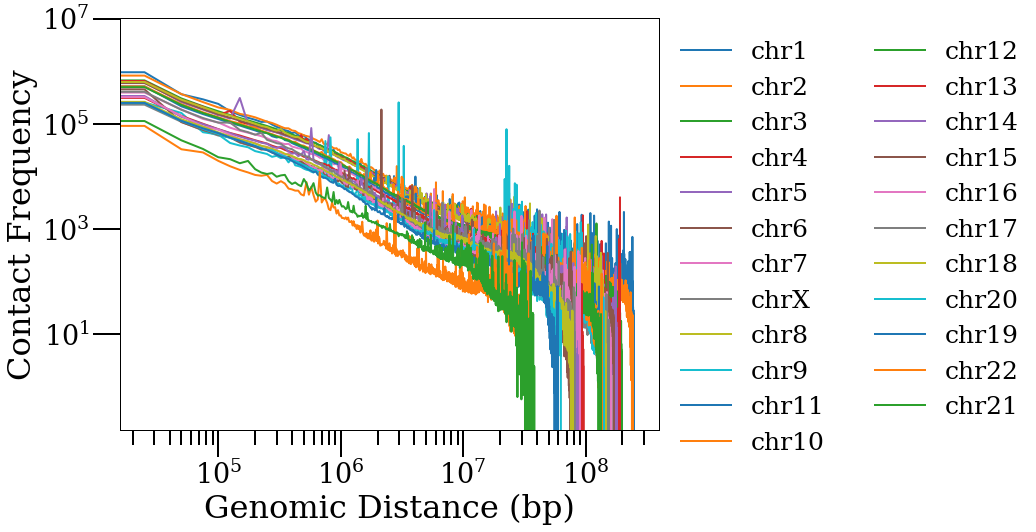

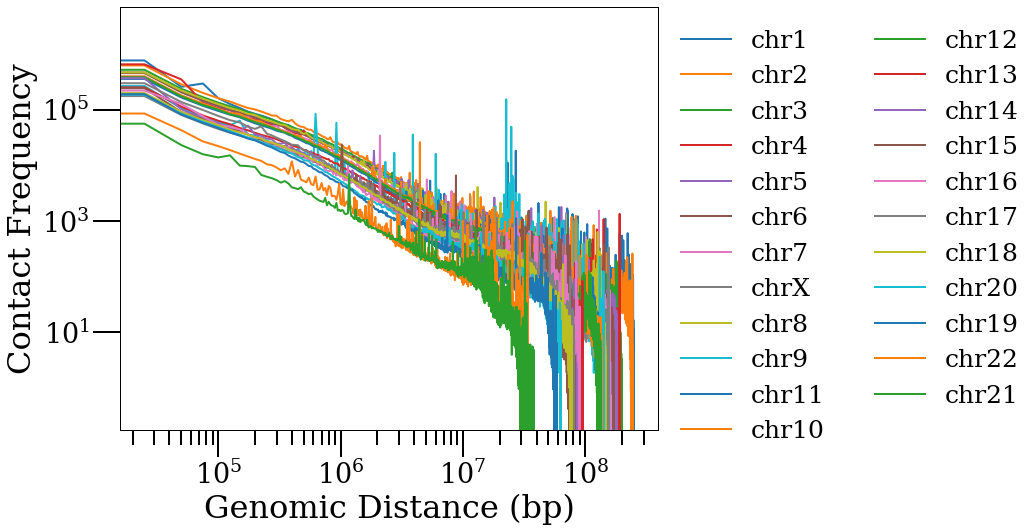

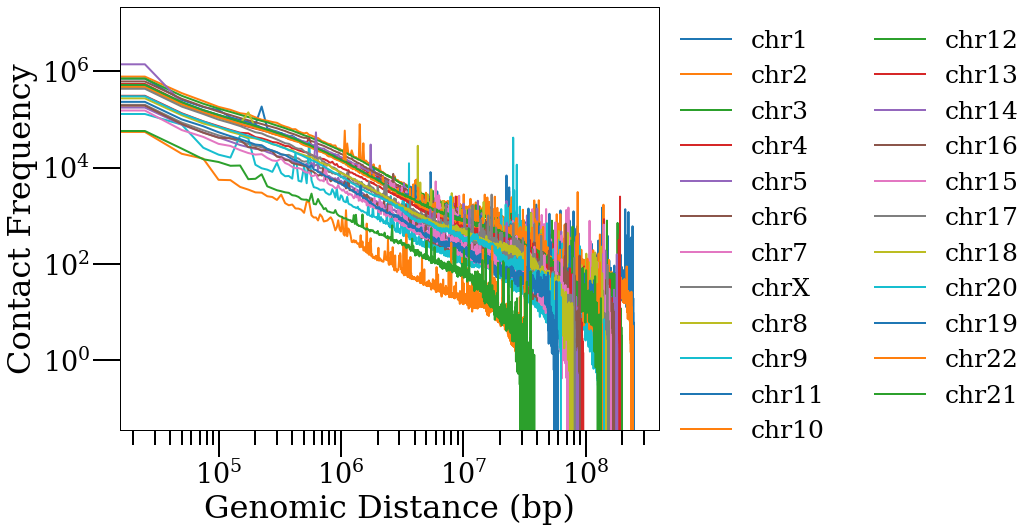

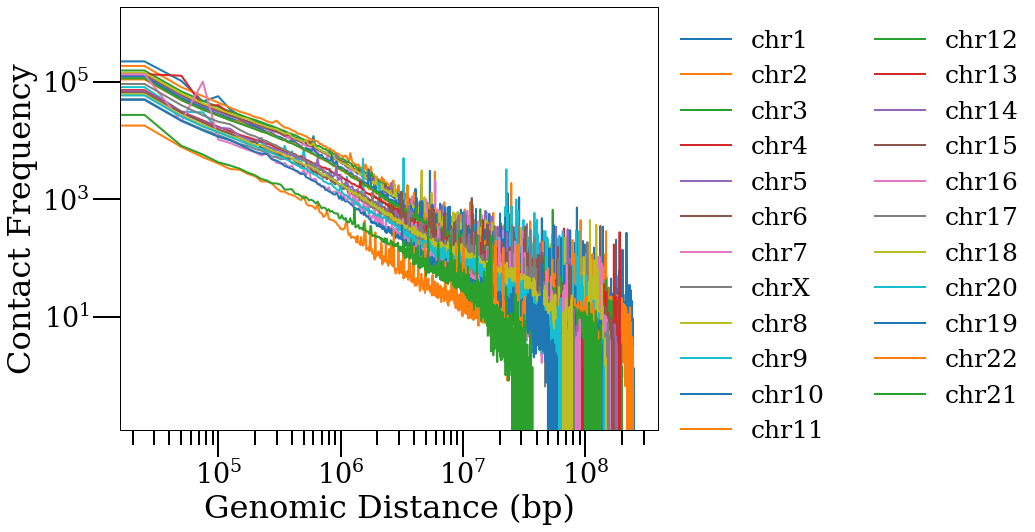

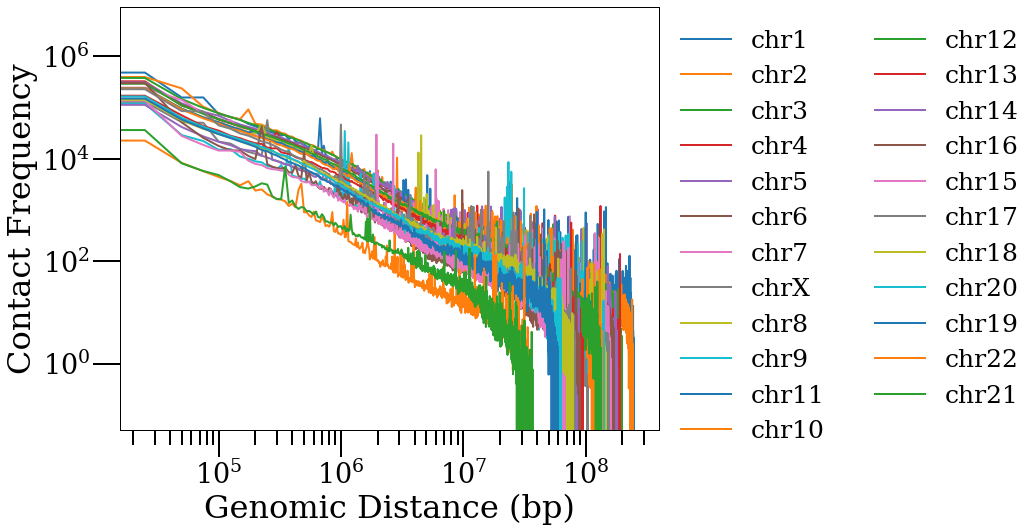

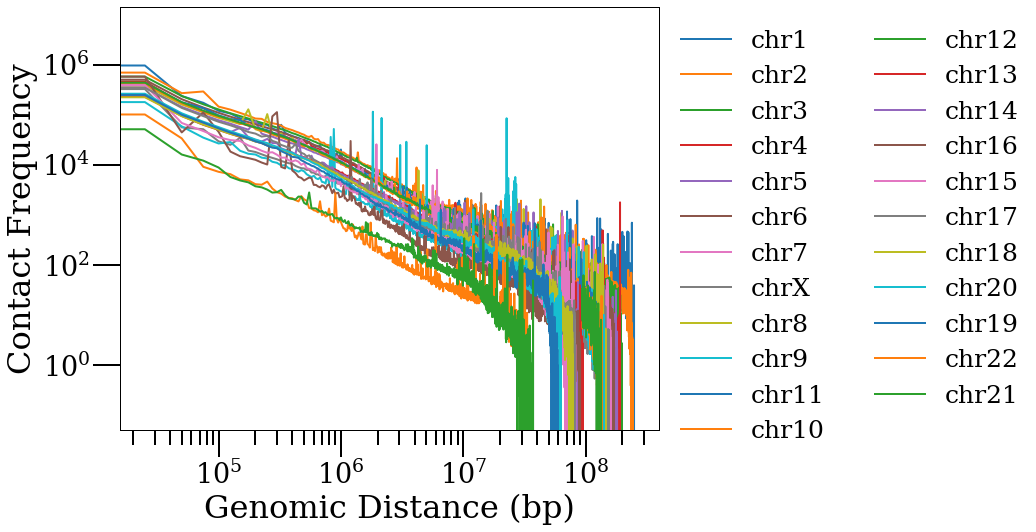

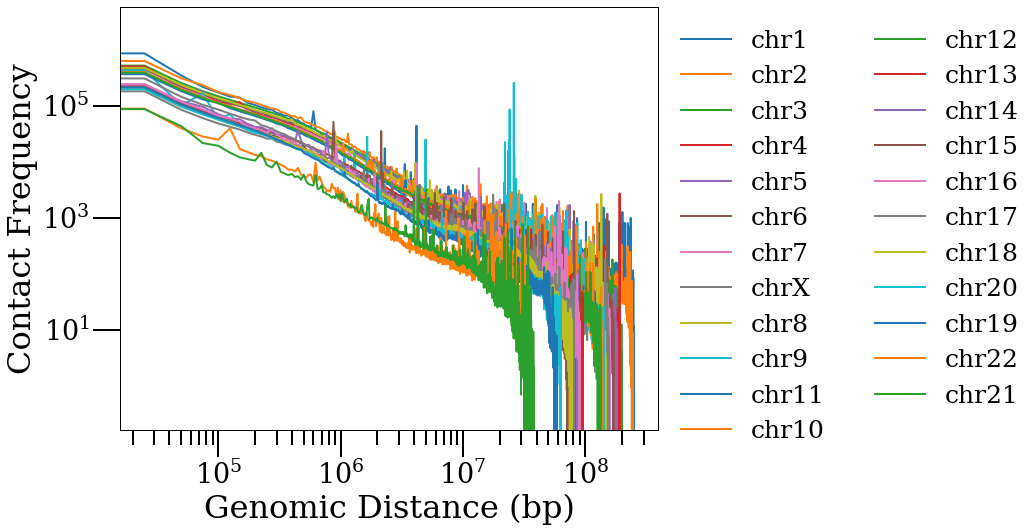

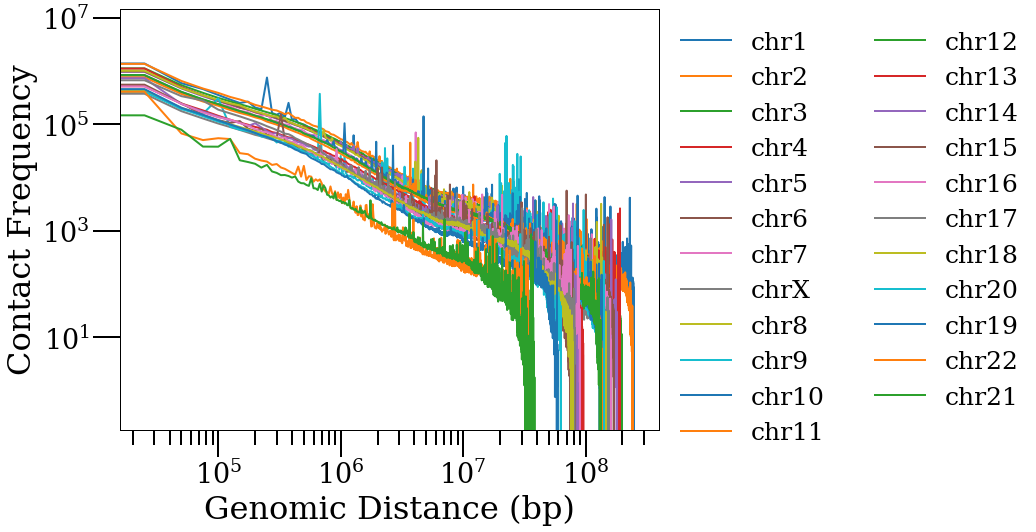

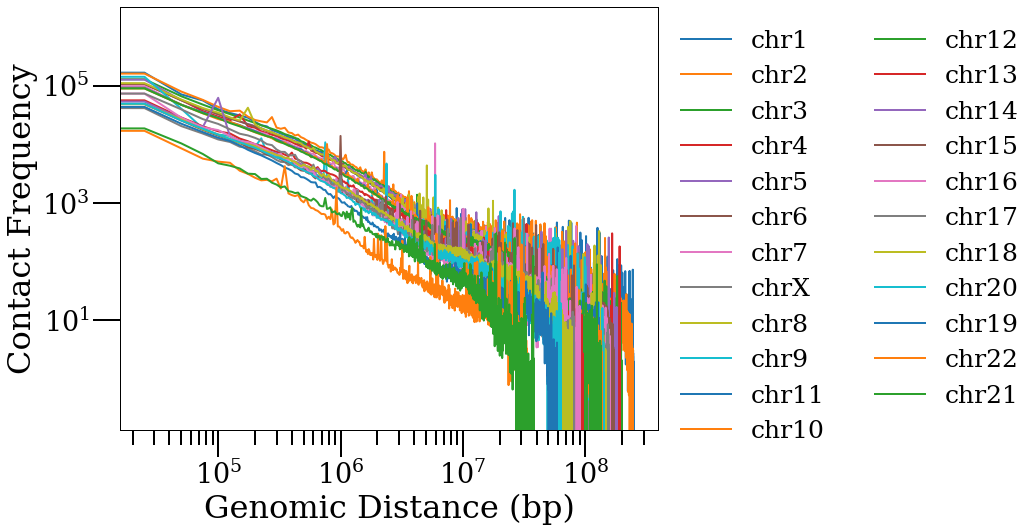

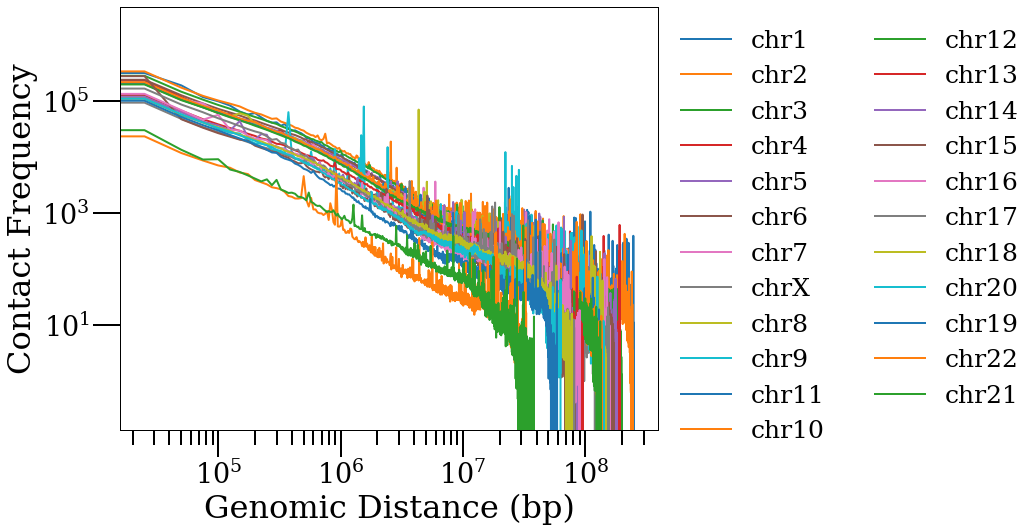

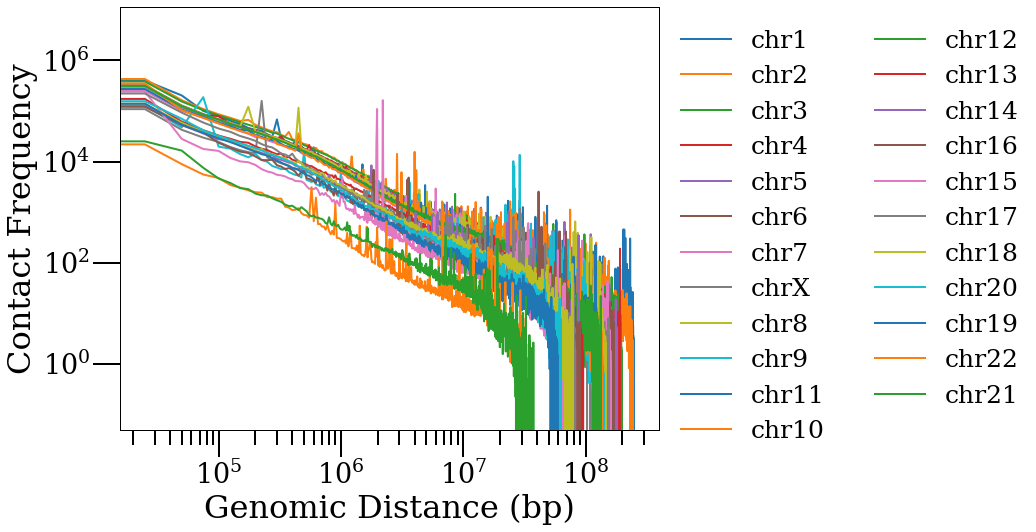

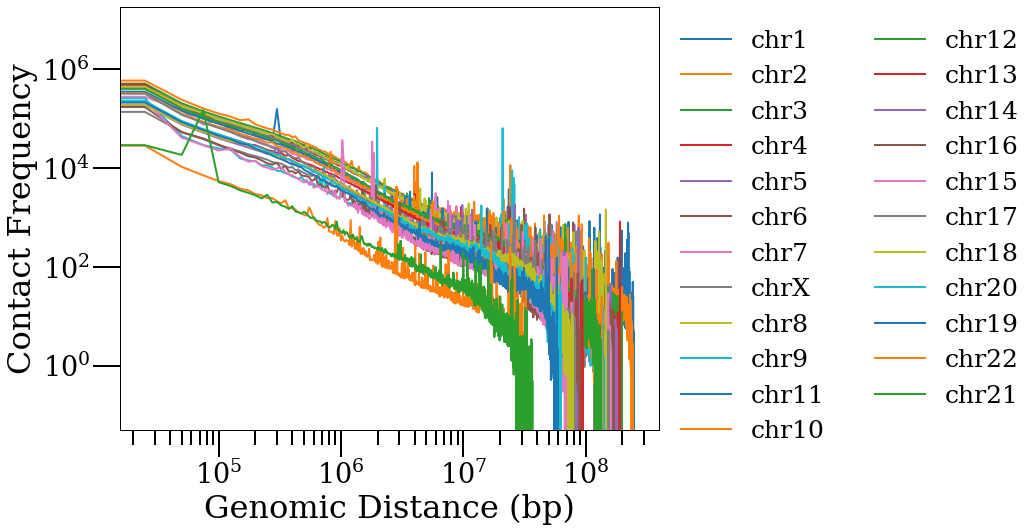

In [14]:
## Inputs -------------------------------------------------------------------##
title = ''
label = 'Contact Probability vs. Genomic Distance'
contacts_parsed_dir = '/contacts_parsed'
fig_name = 'Contact Frequency All Chroms'
fig_type = '.png'

## Plot contact frequency versus genomic distance by chromosome--------------##

for cond in conds:
    cond_path = hic_analysis_path+experiment_name+all_contacts_dir+cond
    
    reps = glob.glob(cond_path+'/*')
    for rep in reps:
        rep_name = rep.split('/')[-1]
        rep_fig_name = fig_name+' '+cond+' '+rep_name

        fig,ax = set_fig(1,1,l=15,h=8)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
        input_path = rep+contacts_parsed_dir
        input_files = sorted(glob.glob(input_path+'/chr*_contacts_'+str(int(resolution/1000))+'kb.csv'), key=os.path.getsize,reverse=True)

        for file in input_files:
            chrom = file.split('/')[-1].split('_')[0]
            cont_freq = pd.read_csv(file,sep='\t',index_col=0)
            ax.plot(cont_freq.index.values,cont_freq.values,label=chrom)

        ax.legend(frameon=False,bbox_to_anchor=(1.0,1.0),ncol=2)
        #ax.set_xlim(resolution,3*10**8)
        ax.set_xlabel('Genomic Distance (bp)',fontsize=32)
        ax.set_ylabel('Contact Frequency',fontsize=32)

        fig.tight_layout()
        fig.savefig(results_path+rep_fig_name+fig_type,dpi=300)

### Plot Merged Contact Probability versus Genomic Distance

The second plot we generate is the merged contact frequency versus the genomic distance for all chromosomes of each condition. Here, we will be able to resolve if there is a change in contact probability between the conditions defined previously.

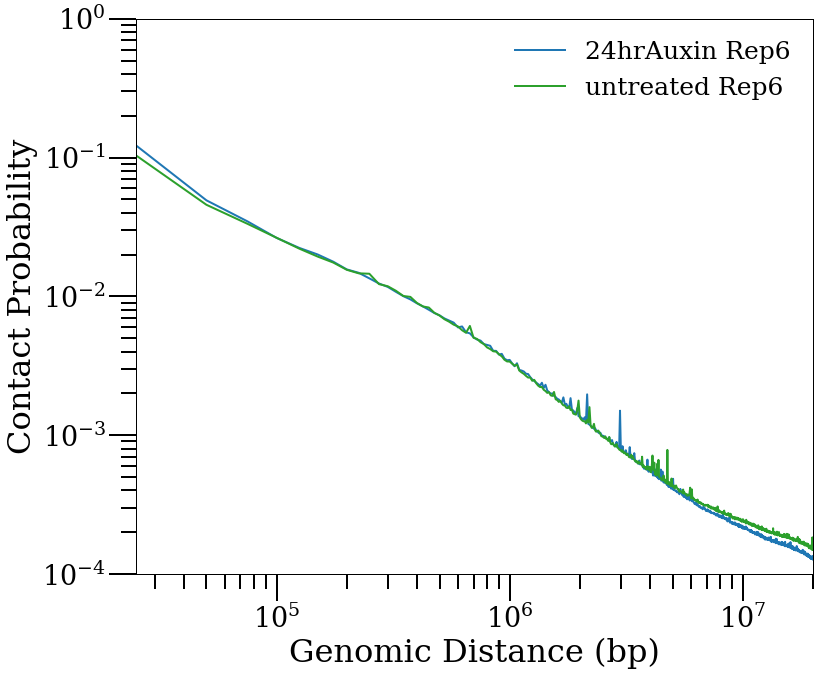

In [15]:
## Inputs -------------------------------------------------------------------##
title = ''
fig_name = 'Contact Probability vs. Genomic Distance'
fig_type = '.png'

## Plot contact probability scaling------------------------------------------##

# set figure axes parameters
fig,ax = set_fig(1,1,12,10)
ax.set_xscale('log')
ax.set_yscale('log')

for i,cond in enumerate(conds):
    
    # Define paths and variables for plot
    cond_path = hic_analysis_path+experiment_name+cont_prob_dir+cond
    color_data = 'C'+str(2*i) # Colors: https://matplotlib.org/2.0.2/users/colors.html
    cond_label = label_dict[cond]
    
    # Loop through contact files and grab contact probability values
    reps = glob.glob(cond_path+'/'+cond+'_*_'+cont_prob_label+'cont_prob_'+str(int(resolution/1000))+'kb.csv')
    for rep_file in reps:
        cont_prob = pd.read_csv(rep_file,index_col=0)
        ax.plot(cont_prob.index,cont_prob.values,color=color_data,label=cond_label+' '+rep_name)

# Set parameters for plot
#ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18) # Put legend outside if many reps
ax.legend(frameon=False)
ax.set_xlabel('Genomic Distance (bp)',fontsize=32)
ax.set_ylabel('Contact Probability',fontsize=32)
ax.set_xlim(resolution,2*10**7,2)
ax.set_ylim(10**-4,1)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_title(title,fontsize=30)

# Layout parameters and save figure
plt.tight_layout()
plt.savefig(results_path+fig_name+fig_type)

## Contact Probability Scaling Analysis: Linear Regression (No MWA)
Now that contact probability has been generated and plotted, we can calculate the contact probability scaling using linear regression. This cell will call on ```calc_cont_prob_scaling()``` and pull the results from the function into a new data frame. As a reminder, the final output looks like this:

<br>

```
          label    s_mean s_intercept     s_err     s_std s_rsquared
CTRL_mega  CTRL -1.340508    5.619405  0.007128  0.029582   0.993539
```

<br>

In [16]:
##-----------Calculate contact probability scaling using linear regression fit to contact probability-----------##

# Generate empty data frame to hold analysis in 
fit_df = pd.DataFrame(columns=['label','s_mean','s_intercept','s_err','s_std','s_rsquared'])

for i,cond in enumerate(conds):
    
    # Define paths
    cond_path = hic_analysis_path+experiment_name+cont_prob_dir+cond
    cond_label = label_dict[cond]
    
    # Get reps
    reps = glob.glob(cond_path+'/'+cond+'_*_'+cont_prob_label+'cont_prob_'+str(int(resolution/1000))+'kb.csv')
    for rep_file in reps: 
        
        # Call calc_cont_prob_scaling() and store in fit_result
        fit_result = calc_cont_prob_scaling(rep_file,start,end)
        
        # Extract parameters from OLS fit result
        s_params = fit_result.params
        s_mean = s_params[0] # Mean (S)
        s_intercept = s_params[1] # Intercept with contact probability line
        
        # Extract standard error, deviation, and Rsquared value
        s_err = fit_result.bse[0] # Standard error of parameter estimate for linear regression fit
        s_std = np.sqrt(fit_result.mse_resid) # Standard deviation = root-mean-square deviation of residuals
        s_rsquared = fit_result.rsquared # Rsquared residual value
        
        # Store in temp_df, then append to fit_df (the final result)
        temp_df = pd.DataFrame([[cond_label,s_mean,s_intercept,s_err,s_std,s_rsquared]],index=[cond+'_'+rep_name],columns=['label','s_mean','s_intercept','s_err','s_std','s_rsquared'])
        fit_df = fit_df.append(temp_df)

<ipython-input-16-51c121d69148>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_df = fit_df.append(temp_df)
<ipython-input-16-51c121d69148>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fit_df = fit_df.append(temp_df)


### Plot Contact Probability vs. Genomic Distance Linear Regression

Here we add the linear regression of the contact probability scaling on the merged contact frequency versus the genomic distance for all chromosomes of each condition plot. For the user-defined region, the plot will also include the average value of ***S*** (the derivative of the curve).

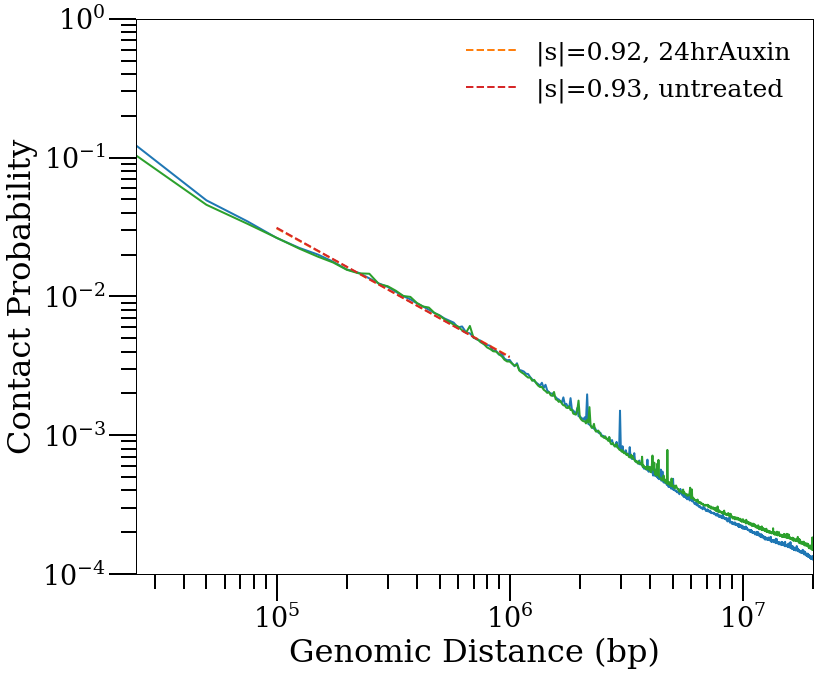

In [17]:
## Inputs -------------------------------------------------------------------##
title = ''
fig_name = 'Contact Probability vs. Genomic Distance Linear Regression'
fig_type = '.png'

## Plot contact probability scaling------------------------------------------##

# set figure axes parameters
fig,ax = set_fig(1,1,12,10)
ax.set_xscale('log')
ax.set_yscale('log')

for i,cond in enumerate(conds):
    
    # Define paths and variables for plot
    cond_path = hic_analysis_path+experiment_name+cont_prob_dir+cond
    color_data = 'C'+str(2*i)
    color_fit = 'C'+str(2*i+1)
    cond_label = cond_labels[i]
    
    # Empty data frame for plotting derivative, S
    fit_df_cond = fit_df[[cond_label in s for s in fit_df.label]]
    
    for rep in fit_df_cond.index:
        
        # Read in contact proabilities 
        rep_file = cond_path+'/'+cond+'_'+cond+'_'+cont_prob_label+'cont_prob_'+str(int(resolution/1000))+'kb.csv'
        cont_prob = pd.read_csv(rep_file,index_col=0)
        ax.plot(cont_prob.index,cont_prob.values,color=color_data)

        # Plot linear regression fit
        fit_params = fit_df.loc[rep,['s_mean','s_intercept']]
        x = np.linspace(start,end,100)
        y = fit_params['s_intercept']+fit_params['s_mean']*x
        rsquared = fit_df.loc[rep,['s_rsquared']]

        #ax.plot(10**x,10**y,color = color_fit,linestyle='dashed',label='|s|=%0.2f, '%(-fit_params['s_mean'])+cond_label+'\n$R^2$=%0.4f '%(rsquared))
        ax.plot(10**x,10**y,color = color_fit,linestyle='dashed',label='|s|=%0.2f, '%(-fit_params['s_mean'])+cond_label)

#ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18) # Put legend outside if many reps
ax.legend(frameon=False)
ax.set_xlabel('Genomic Distance (bp)',fontsize=32)
ax.set_ylabel('Contact Probability',fontsize=32)
#ax.set_xlim(resolution,3*10**7,2)
#ax.set_xlim(10**(start-0.1),10**(end+0.1))
#ax.set_ylim(10**-3,10**-2)
ax.set_xlim(resolution,2*10**7,2)
ax.set_ylim(10**-4,1)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_title(title,fontsize=30)

# Layout parameters and save figure
plt.tight_layout()
#plt.savefig(results_path+fig_name+fig_type)

In [48]:
### Calculate pairwise p-values for each condition and write to stats file, assuming s follows a normal distribution ###
p_value = pd.DataFrame(columns = fit_df.index, index = fit_df.index)
for s1,s2 in itertools.combinations(fit_df.index, 2):
    # Generate random numbers from a normal distribution representing each of the linear regression fits being compared
    rvs1 = norm.rvs(loc=-1.0*fit_df.loc[s1,'s_mean'],scale=fit_df.loc[s1,'s_std'],size=100)
    rvs2 = norm.rvs(loc=-1.0*fit_df.loc[s2,'s_mean'],scale=fit_df.loc[s2,'s_std'],size=100)
    
    p_value.loc[s1,s2] = ttest_ind(rvs1,rvs2,equal_var=False)[1]
    p_value.loc[s2,s1] = ttest_ind(rvs1,rvs2,equal_var=False)[1]
#p_value.to_csv(results_path+'s_stats_file.csv')
p_value

,Control_mega,Treated6hr_mega
Control_mega,NaN,6.67215e-248
Treated6hr_mega,6.67215e-248,NaN


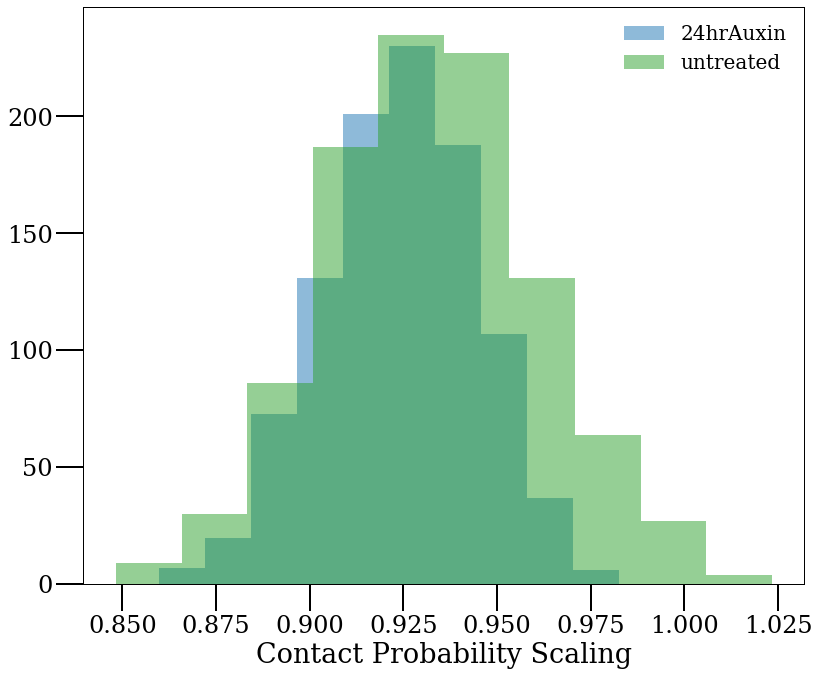

In [18]:
### Input #####################################################################################
title = 'Linear Regression Fit Histogram'
label = 'Linear Regression Fit Histogram '

### Plot histogram of distribution of s values between conditions based on mwa ###
fig,ax = set_fig(1,1,12,10)

for i,cond in enumerate(conds):
    color = 'C'+str(2*i)
    fit_df_cond = fit_df[fit_df.index.to_series().str.contains(cond)]
    cond_label = label_dict[cond]
    for rep in fit_df_cond.index:
        # Generate normal distribution for values of contact probability scaling centered around 's_mean'
        # with standard deviation 's_std'
        rvs = norm.rvs(loc=-1.0*fit_df.loc[rep,'s_mean'],scale=fit_df.loc[rep,'s_std'],size=1000)
        np.savetxt(results_path+cond+'linear_regression_fit_hist.txt',rvs)
        ax.hist(rvs,alpha=0.5,label=cond_label,color=color)

ax.set_xlabel('Contact Probability Scaling',fontsize=27)
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.set_title(title,fontsize=30)
#ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
ax.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.savefig(results_path+label+'.png')

# Contact Probability Scaling Analysis: MWA Linear Regression

In [20]:
### Input #####################################################################################
window = 5

### Create dataframe storing all mwa s values (fit by linear regression) for all conditions ###
s_mwa_all = pd.DataFrame()

x = 0
for i,cond in enumerate(conds):
    cond_path = hic_analysis_path+experiment_name+cont_prob_dir+cond
    cond_label = label_dict[cond]
    
    reps = glob.glob(cond_path+'/'+cond+'_*_'+cont_prob_label+'cont_prob_'+str(int(resolution/1000))+'kb.csv')
    for rep_file in reps:
        num_fit,s_mwa = calc_cont_prob_scaling_mwa(rep_file,start,end,window)
        
        s_mwa.iloc[:,1] = s_mwa.iloc[:,1]*-1.0
        if x==0:
            s_mwa_all = pd.concat([s_mwa_all,s_mwa])
            print('Number fitted points: '+str(num_fit)+'\n')
        else:
            s_mwa_all = s_mwa_all.merge(s_mwa,how='left',left_on='dist',right_on='dist')
        x += 1
        
s_mwa_all = s_mwa_all.set_index('dist')
s_mwa_all = s_mwa_all.dropna()

/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucas

Number fitted points: 35



/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucascarter/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/lucas

In [21]:
### Determine number of replicates per condition
reps_per_cond = np.zeros(len(conds))

for i,cond in enumerate(conds):
    s_mwa_cond = s_mwa_all[s_mwa_all.columns[s_mwa_all.columns.to_series().str.contains(cond)]]
    reps_per_cond[i] = len(s_mwa_cond.columns)

In [22]:
### Calculate pairwise p-values for each condition and write to stats file ###
p_value = pd.DataFrame(columns = s_mwa_all.columns, index = s_mwa_all.columns)
for s1,s2 in itertools.combinations(s_mwa_all.columns, 2):
    p_value.loc[s1,s2] = round(ttest_ind(s_mwa_all[s1].values,s_mwa_all[s2].values)[1],3)
    p_value.loc[s2,s1] = round(ttest_ind(s_mwa_all[s2].values,s_mwa_all[s1].values)[1],3)
p_value.to_csv(results_path+'s_stats_file_window_'+str(window*5)+'_bp.csv')
p_value

,24hrAuxin_24hrAuxin,untreated_untreated
24hrAuxin_24hrAuxin,NaN,0.782
untreated_untreated,0.782,NaN


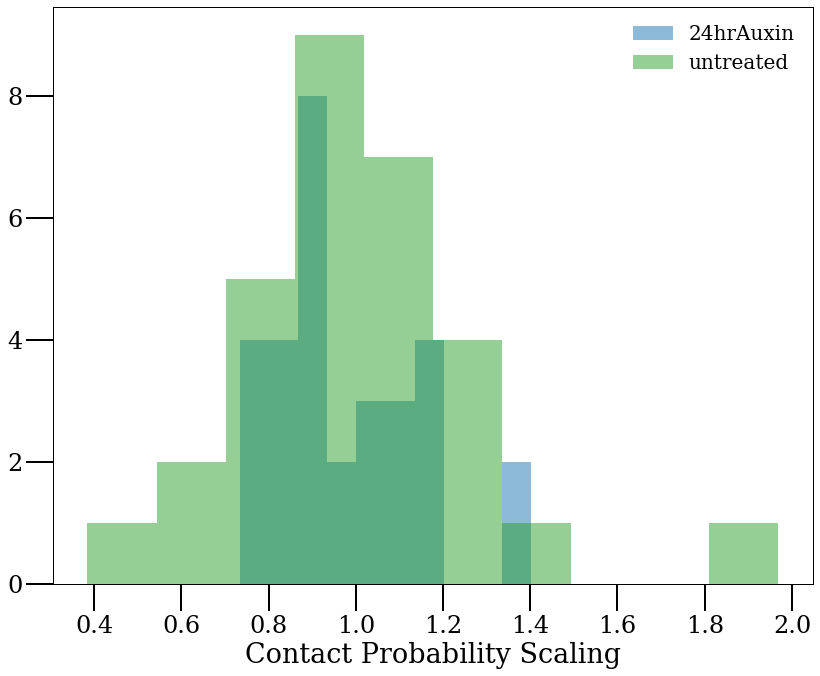

In [23]:
### Input #####################################################################################
title = 'MWA Linear Regression'
label = 'MWA Regression Histogram '+str(window*5)+' bp'

### Plot histogram of distribution of s values between conditions based on mwa ###
fig,ax = set_fig(1,1,12,10)

for i,cond in enumerate(conds):
    color = 'C'+str(2*i)
    s_mwa_cond = s_mwa_all[s_mwa_all.columns[s_mwa_all.columns.to_series().str.contains(cond)]]
    for rep in s_mwa_cond.columns:
        ax.hist(s_mwa_cond[rep].values,alpha=0.5,label=cond_labels[i],color=color)

ax.set_xlabel('Contact Probability Scaling',fontsize=27)
ax.tick_params(axis='both', which='major', labelsize=24)
#ax.set_title(title,fontsize=30)
#ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
ax.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.savefig(results_path+label+'.png')

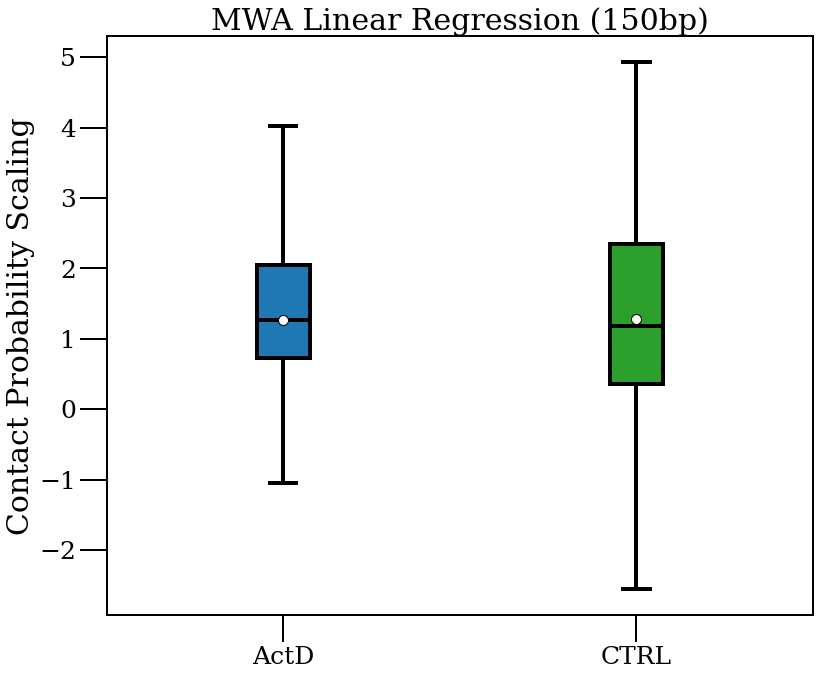

In [89]:
### Input #####################################################################################
title = 'MWA Linear Regression (150bp)'
label = 'MWA Regression Boxplot No Fliers '+str(window*5)+' bp'
outliers = False

# Plot differences in contact probability scaling per condition based on moving window average (Boxplot)
fig,ax = set_fig(1,1,12,10)

bp = ax.boxplot(s_mwa_all.values,patch_artist=True,showmeans=True,showfliers=outliers)

for i,cond in enumerate(conds):
    color = 'C'+str(2*i)
    start_i = int(sum(reps_per_cond[:i]))
    end_i = int(reps_per_cond[i] + sum(reps_per_cond[:i]))
    
    for box in bp['boxes'][start_i:end_i]:
        box.set(color='k',linewidth=4)
        box.set(facecolor=color)

for box in bp['fliers']:
    box.set(color='k')

for box in bp['medians']:
    box.set(color='k',linewidth=4)

for box in bp['means']:
    box.set(marker='o')
    box.set(markersize=10)
    box.set(markerfacecolor='w')
    box.set(markeredgecolor='k')

for box in bp['whiskers']:
    box.set(color='k',linewidth=4)

for box in bp['caps']:
    box.set(color='k',linewidth=4) 

ax.set_xticks(np.linspace(1,len(cond_labels),len(cond_labels)))
#ax.set_xticklabels(labels,fontsize=27,rotation='vertical')
ax.set_xticklabels(cond_labels,fontsize=27)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel('Contact Probability Scaling',fontsize=30)
ax.set_title(title,fontsize=30)

plt.tight_layout()
plt.savefig(results_path+label+'.png')